# Creating the Escudero-Sanz eye model through ZOSPY
This example demonstrates how to create and analyze a virtual version of the [eye model described by I. Escudero-Sanz and R. Navarro](https://doi.org/10.1364/JOSAA.16.001881) through ZOSPy.

In [1]:
import zospy as zp
import pandas as pd
import matplotlib.pyplot as plt

from zospy import solvers
from zospy.analyses import OnComplete

## Define constants

In [2]:
wavelength = 543.0

In [3]:
refinds = pd.DataFrame(
    columns=[458, 543, 589.3, 632.8],
    index=["Cornea", "Aqueous", "Lens", "Vitreous"],
    data=[
        [1.3828, 1.3777, 1.376, 1.3747],
        [1.3445, 1.3391, 1.3374, 1.336],
        [1.4292, 1.4222, 1.42, 1.4183],
        [1.3428, 1.3377, 1.336, 1.3347],
    ],
)

In [4]:
# Cornea front
cf_radius = 7.72
cf_conic = -0.26
cf_thickness = 0.55

# Cornea back
cb_radius = 6.50
cb_conic = 0
cb_thickness = 3.05

# Pupil
pupil_radius = 1.5

# Lens front
lf_radius = 10.20
lf_conic = -3.1316
lf_thickness = 4.00

# Lens back
lb_radius = -6.00
lb_conic = -1.0
lb_thickness = 16.3202

# Retina
ret_radius = -12.00
ret_conic = 0

## Connect to ZOS

In [5]:
zos = zp.ZOS()
zos.wakeup()

In [6]:
zos.connect_as_extension()

True

In [7]:
oss = zos.get_primary_system()

## Create model

In [8]:
oss.new()
oss.make_sequential()

True

In [9]:
# set wavelength
wl_1 = oss.SystemData.Wavelengths.GetWavelength(1)
wl_1.Wavelength = wavelength / 1000  # convert to nanometer

# Set aperture type
oss.SystemData.Aperture.ApertureType = zp.constants.SystemData.ZemaxApertureType.FloatByStopSize

In [10]:
n_surf = 0

# object
r_obj = oss.LDE.GetSurfaceAt(0)
r_obj.Comment = "Object"
n_surf += 1

# inputbeam (for esthetic reasons)
r_ipbeam = oss.LDE.InsertNewSurfaceAt(n_surf)
r_ipbeam.Comment = "InputBeam"
r_ipbeam.Thickness = 10
n_surf += 1

# cornea front
cf_surf = oss.LDE.InsertNewSurfaceAt(n_surf)
cf_surf.Comment = "Cornea Front"
# Following statement not needed but given as example
zp.functions.lde.surface_change_type(cf_surf, zp.constants.Editors.LDE.SurfaceType.Standard)

cf_surf.Radius = cf_radius
cf_surf.Conic = cf_conic
cf_surf.SemiDiameter = 6
cf_surf.MechanicalSemiDiameter = 6
cf_surf.Thickness = cf_thickness
solvers.material_model(cf_surf.MaterialCell, refinds.loc["Cornea", wavelength], 0, 0)
n_surf += 1

# cornea back
cb_surf = oss.LDE.InsertNewSurfaceAt(n_surf)
cb_surf.Comment = "Cornea Back"
cb_surf.Radius = cb_radius
cb_surf.Conic = cb_conic
cb_surf.SemiDiameter = 5
cb_surf.MechanicalSemiDiameter = 6
cb_surf.Thickness = cb_thickness
solvers.material_model(cb_surf.MaterialCell, refinds.loc["Aqueous", wavelength], 0, 0)
n_surf += 1

# iris/pupil
iris_surf = oss.LDE.GetSurfaceAt(n_surf)
iris_surf.Comment = "Iris"
iris_surf.SemiDiameter = pupil_radius
iris_surf.MechanicalSemiDiameter = 6
solvers.material_model(iris_surf.MaterialCell, refinds.loc["Aqueous", wavelength], 0, 0)
n_surf += 1

# Lens front
lf_surf = oss.LDE.InsertNewSurfaceAt(n_surf)
lf_surf.Comment = "Lens Front"
lf_surf.Radius = lf_radius
lf_surf.Conic = lf_conic
lf_surf.SemiDiameter = 4.5
lf_surf.MechanicalSemiDiameter = 4.5
lf_surf.Thickness = lf_thickness
solvers.material_model(lf_surf.MaterialCell, refinds.loc["Lens", wavelength], 0, 0)
n_surf += 1

# Lens back
lb_surf = oss.LDE.InsertNewSurfaceAt(n_surf)
lb_surf.Comment = "Lens Back"
lb_surf.Radius = lb_radius
lb_surf.Conic = lb_conic
lb_surf.SemiDiameter = 4.5
lb_surf.MechanicalSemiDiameter = 4.5
lb_surf.Thickness = lb_thickness
solvers.material_model(lb_surf.MaterialCell, refinds.loc["Vitreous", wavelength], 0, 0)
n_surf += 1

# Retina
ret_surf = oss.LDE.GetSurfaceAt(n_surf)
ret_surf.Comment = "Retina"
ret_surf.Radius = ret_radius
ret_surf.Conic = ret_conic
ret_surf.SemiDiameter = 12
solvers.material_model(ret_surf.MaterialCell, refinds.loc["Vitreous", wavelength], 0, 0)

## Draw

In [11]:
cf_surf.DrawData.DoNotDrawEdgesFromThisSurface = False
cb_surf.DrawData.DoNotDrawEdgesFromThisSurface = True
iris_surf.DrawData.DoNotDrawEdgesFromThisSurface = True
lf_surf.DrawData.DoNotDrawEdgesFromThisSurface = False
lb_surf.DrawData.DoNotDrawEdgesFromThisSurface = True

In [12]:
draw3d = zp.analyses.new_analysis(oss, zp.constants.Analysis.AnalysisIDM.Draw3D, settings_first=False)
shaded = zp.analyses.new_analysis(oss, zp.constants.Analysis.AnalysisIDM.ShadedModel, settings_first=False)

## Analyze

In [13]:
psf = zp.analyses.psf.huygens_psf(oss, "256x256", "256x256", normalize=True, oncomplete=OnComplete.Sustain)

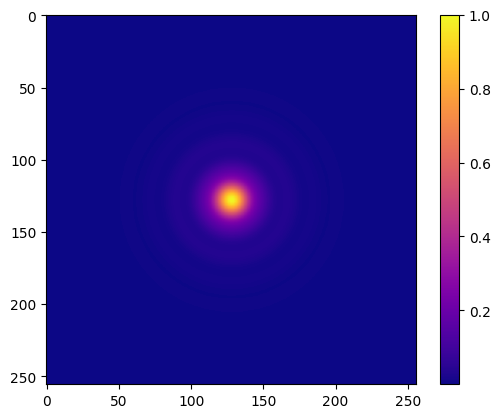

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(psf.Data, cmap="plasma")
plt.colorbar(im)

## Modify input field

In [15]:
field1 = oss.SystemData.Fields.GetField(1)

In [16]:
field1.Y = 15

## Redo analyses

In [17]:
draw3d.Apply()

In [18]:
psf = zp.analyses.psf.huygens_psf(oss, "256x256", "256x256", normalize=True, oncomplete=OnComplete.Sustain)

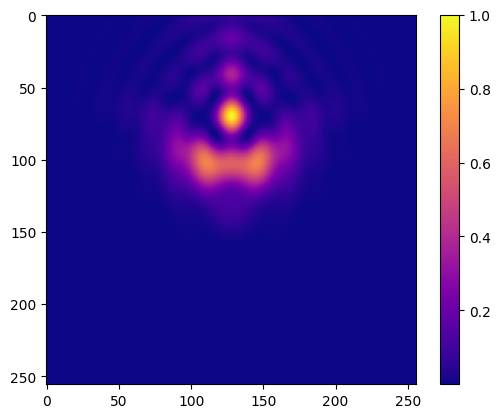

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(psf.Data, cmap="plasma")
plt.colorbar(im)